<a href="https://colab.research.google.com/github/Nagalakshmigithub62/NLP2/blob/main/NLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train.txt', sep='\t')  # Ensure to use the correct delimiter if it's not comma

In [ ]:
data['label'].value_counts()

label
others    14948
angry      5506
sad        5463
happy      4243
Name: count, dtype: int64

In [ ]:
def extract_emojis(text):
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "\U00002702-\U000027B0"  # other symbols
                               "\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

In [ ]:
data['turn1'] = data['turn1'].astype(str)
data['turn2'] = data['turn2'].astype(str)
data['turn3'] = data['turn3'].astype(str)

# Apply the emoji extraction function to each turn
data['turn1_emojis'] = data['turn1'].apply(extract_emojis)
data['turn2_emojis'] = data['turn2'].apply(extract_emojis)
data['turn3_emojis'] = data['turn3'].apply(extract_emojis)

In [ ]:
from collections import Counter
all_emojis = data['turn1_emojis'].sum() + data['turn2_emojis'].sum() + data['turn3_emojis'].sum()

# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)

In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters, numbers, and punctuations (except for hashtags and @mentions)
    text = re.sub("[^a-zA-Z#@]", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    exclude =string.punctuation
    words = [word for word in words if word not in exclude]

    # Lemmatize words based on POS tags
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(words)
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noun
            pos = 'n'
        elif tag.startswith('VB'):  # Verb
            pos = 'v'
        elif tag.startswith('JJ'):  # Adjective
            pos = 'a'
        else:
            pos = 'n'  # Default to noun
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    text = ' '.join(lemmatized_words)
    return text

In [ ]:
data['turn1_clean'] = data['turn1'].apply(preprocess_text)
data['turn2_clean'] = data['turn2'].apply(preprocess_text)
data['turn3_clean'] = data['turn3'].apply(preprocess_text)

In [ ]:
data['clean_text'] = data['turn1_clean'] + ' ' + data['turn2_clean'] + ' ' + data['turn3_clean']

In [ ]:
!pip install demoji

In [ ]:
import demoji

demoji.download_codes()


<ipython-input-13-610bed6913c2>:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
data['turn1_emojis_description'] = data['turn1_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
data['turn2_emojis_description'] = data['turn2_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
data['turn3_emojis_description'] = data['turn3_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
data['emojis_description'] = data['turn1_emojis_description'] + ' ' + data['turn2_emojis_description'] + ' ' + data['turn3_emojis_description']

In [ ]:
data['emojis_description'].apply(preprocess_text)

0                       
1                       
2                       
3                       
4                       
              ...       
30155                   
30156    loudly cry face
30157                   
30158                   
30159                   
Name: emojis_description, Length: 30160, dtype: object

In [ ]:
data.drop_duplicates("clean_text", inplace=True)

In [ ]:
data['combined_text'] = data['clean_text'] + ' ' + data['emojis_description']

In [ ]:
# Preprocess the data
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['combined_text'])
sequences = tokenizer.texts_to_sequences(data['combined_text'])

In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert the labels to categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=30000, output_dim=128, input_length=50),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           3840000   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 128)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 128)           164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                  

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/5
372/372 [==============================] - 254s 642ms/step - loss: 0.9158 - accuracy: 0.6524 - val_loss: 0.5816 - val_accuracy: 0.8056
Epoch 2/5
372/372 [==============================] - 244s 655ms/step - loss: 0.5414 - accuracy: 0.8297 - val_loss: 0.5271 - val_accuracy: 0.8203
Epoch 3/5
372/372 [==============================] - 236s 634ms/step - loss: 0.4517 - accuracy: 0.8577 - val_loss: 0.5331 - val_accuracy: 0.8171
Epoch 4/5
372/372 [==============================] - 233s 626ms/step - loss: 0.3916 - accuracy: 0.8763 - val_loss: 0.5455 - val_accuracy: 0.8139
Epoch 5/5
372/372 [==============================] - 257s 690ms/step - loss: 0.3418 - accuracy: 0.8935 - val_loss: 0.6201 - val_accuracy: 0.8061


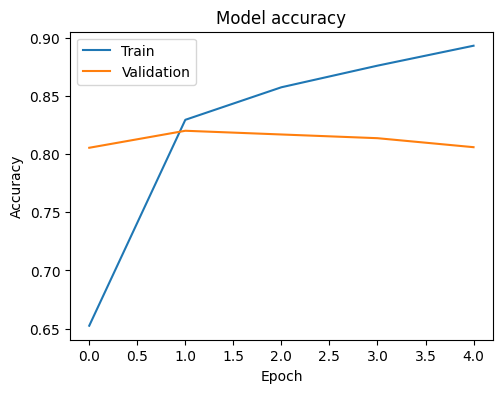

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



plt.show()

186/186 [==============================] - 39s 136ms/step


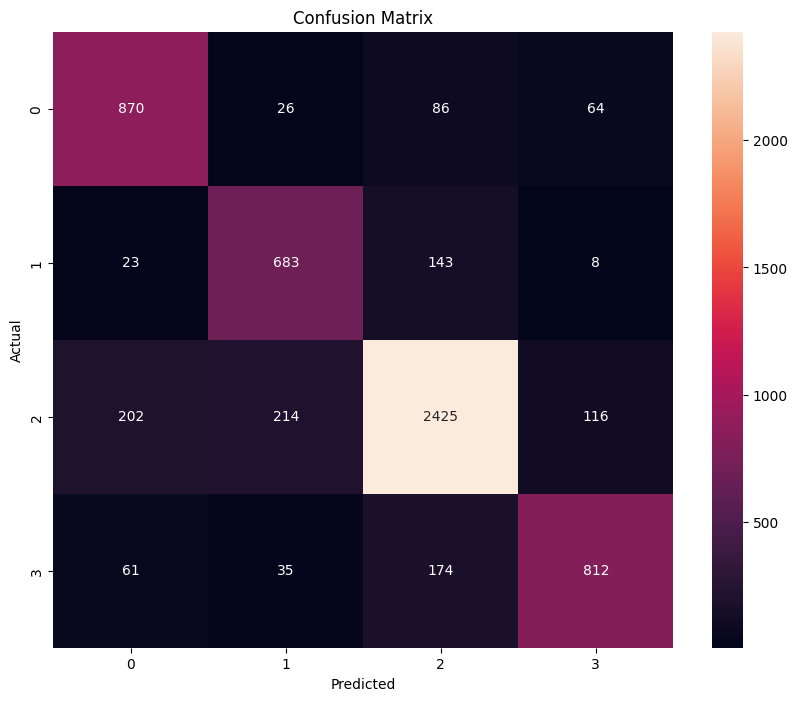

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1046
           1       0.71      0.80      0.75       857
           2       0.86      0.82      0.84      2957
           3       0.81      0.75      0.78      1082

    accuracy                           0.81      5942
   macro avg       0.78      0.80      0.79      5942
weighted avg       0.81      0.81      0.81      5942



In [ ]:
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n")
print(class_report)